# Summary
In summary, it seems that the trained model performs very well on historical data. However, given the qualitative results given in [praw](https://github.com/DavidHarar/Reddit/blob/main/notebooks/detect_comments_using_praw.ipynb) notebook, it seems that the model may overfit the data a bit and more observations are needed to be labeled.  

#### **Length**
BERT-like models can handle up to 512 tokens. Tokens are usually sub-parts of words [[1]](https://arxiv.org/abs/1508.07909). Longer sequences just getting trancuated into 512 tokens. In general, it seems that there is no substential mass at 512, meaning that the vast majority of our texts are spreaded across less than 512 tokens.  

#### **Embeddings**
By construction of BERT-like models, the `[CLS]` token catches the meaning of the entire sentence. It is usually a classifier that is built on top of the `[CLS]` token to classify an input sequence. I compared the embeddings of three models by projecting them onto $R^2$ using the `umap` algorithm and plotting them. If the model actually catches something of the meaning of the sentences, coloring points by label and using `umap` should leave us with separated clusters of sentences. The versions I compared were  
1. Roberta, pre-trained
2. Roberta, continue pre-training using Reddit's data
3. Roberta, continue pre-training using Reddit's data, then fine-tuned using labeled Reddit's data.
Interestingly, we can see that the pre-trained model divides the sentences into two clusters, with a similar mass of each label in every cluster. Reddit's comments are relatively hard to grasp, often sarcastic or indirect. Probably, one can divide them into groups based on other criteria than being antisemitic or not. Then, continuing the pre-training yields a seemingly one big uniform cloud. It probably means that some of the underlying *general* logic that was learned in the original pre-training was lost. Nevertheless, it is important to note that the results from using the version that continued the pre-training achieved better precision around higher scores, which is our area of interest. Lastly, I plot the embeddings of the fine-tuned model. We can see two distinct clusters, with one of the labels being the majority color in each. That means that the model could learn the task it was trained to.  

#### **Scores Distribution**
We can see good results in terms of `ROC AUC` (.83) and `AUC PR` (.82). We can also see that around a threshold of .9 we have a good precision. **Because for me, mistakingly portraying a comment as antisemitic or anti-Israeli bares a higher cost than missing a one, I choose to present only comments that scored above .9**

# Analysis

In [1]:
!nvidia-smi

Sat Dec  2 03:34:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install umap-learn requests datashader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=7cb1c618d9e60117d496894da210e595b79d78e58176cdaacd02e41952564a06
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [3]:
# Globals
# ----------
# data locations
ORIGIN = './data/labeled_sample_and_splits/'
DATA_FILE = ORIGIN+'labeled_data_2023-11-07.csv'
train_idx_path = ORIGIN+'train_idx_2023-11-07.npy'
val_idx_path   = ORIGIN+'val_idx_2023-11-07.npy'
test_idx_path  = ORIGIN+'test_idx_2023-11-07.npy'
RELABELED_DATA_FILE = ORIGIN+'relabeled_data_2023-11-07.csv'
AUGMENTED_DATA_FILE = ORIGIN+'train_manually_labeled_augmented_2023-11-08.csv'
HF_BERT_MODEL = 'roberta-base'
device = 'cuda'
# ----------

# imports
import numpy as np
import os
import sys
from google.colab import drive
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import re
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import pandas as pd

from transformers import RobertaTokenizer, RobertaForSequenceClassification

import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn import metrics

drive.mount('/content/drive')
root = '/content/drive/MyDrive/projects/Reddit/'

os.chdir(root)
sys.path.append(root)

Mounted at /content/drive


## utils

In [4]:
def present_umap_embeddings(CLS_embeddings_np, labels_np, n_neighbors):
  cols = ['Not Anti-Israeli', 'Anti-Israeli']
  # initiate umap
  reducer = umap.UMAP(n_neighbors = n_neighbors)

  # fit
  embedding = reducer.fit_transform(CLS_embeddings_np)

  # store results
  embedding_pd = pd.DataFrame(embedding)
  embedding_pd['label'] = pd.Series(labels_np).map({i:x for (i,x) in enumerate(cols)})

  # plot
  plt.figure(figsize=(10,10))
  sns.scatterplot(data = embedding_pd, x=0, y=1, hue = 'label')
  plt.title(f'UMAP projection - {n_neighbors} Neighbors', fontsize=24)
  plt.show()

def report(y_true, y_pred,y_score):
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
  roc_auc = np.round(metrics.auc(fpr, tpr),4)
  precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_score)
  pr_auc = np.round(metrics.auc(recall, precision),4)
  bacc = np.round(metrics.balanced_accuracy_score(y_true, y_pred),4)

  # plots
  plot_df = pd.DataFrame(
      {
          'Label':y_true,
          'Prediction':y_score,
          'Predicted Label':y_pred
          }
      )

  fig, axs = plt.subplots(1, 4, figsize = (12,3))
  sns.histplot(data = plot_df, x = 'Prediction', hue = 'Label', ax=axs[0])
  axs[0].set_title('Scores Distribution')

  axs[1].plot(fpr, tpr)
  axs[1].set_xlabel("False Positive Rate")
  axs[1].set_ylabel("True Positive Rate")
  axs[1].set_title('ROC')

  axs[2].plot(recall, precision)
  axs[2].set_xlabel("Recall")
  axs[2].set_ylabel("Precision")
  axs[2].set_title('PR Curve')

  crosstab = pd.crosstab(plot_df['Label'], plot_df['Predicted Label'], normalize='index')
  sns.heatmap(crosstab, annot=True, fmt='.2f', ax = axs[3])
  plt.tight_layout()
  plt.show()

  # prints
  print(f"Balanced Accuracy: {bacc}")
  print(f"AUC AUC:           {roc_auc}")
  print(f"PR AUC:            {pr_auc}")

def plot_report_on_test(test_dataloader, model, df_to_score=None):
  # create lists to store values
  labels_total = []
  probs_total = []

  # Evaluate data for one epoch
  for batch in test_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # sys.exit(0)

    with torch.no_grad():

      result = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels,
                    return_dict=True)

    loss = result.loss
    logits = result.logits

    probs = torch.softmax(logits, dim=1).detach().cpu().numpy().tolist()
    b_labels = b_labels.detach().cpu().numpy().tolist()
    labels_total += b_labels
    probs_total  += probs

  y_true  = np.squeeze(np.array(labels_total))
  y_pred  = np.array(probs_total).argmax(axis=1)
  y_score = np.array(probs_total)[:,1]

  report(y_true, y_pred,y_score)

  if df_to_score is not None:
    df_to_score['score'] = y_score

    return df_to_score

## Load Data

In [23]:
data = pd.read_csv(DATA_FILE,index_col=0)
data['label'] = data['Negative']

train_idx = np.load(train_idx_path)
val_idx   = np.load(val_idx_path)
test_idx  = np.load(test_idx_path)

data_train_and_val = pd.concat([data.iloc[train_idx,:],
                                data.iloc[val_idx,:]],
                               ignore_index=True)
data = data.iloc[test_idx,:].reset_index(drop=True)

print(f'\nTest data contains {len(data)} observations.')
print('Target distibution')
display(data['label'].value_counts())
data.iloc[:5]


Test data contains 155 observations.
Target distibution


0.0    83
1.0    72
Name: label, dtype: int64

,title,comment,Negative,Natural,Positive,clean_label,label
0,Israeli newspaper exposes how gov't helps E. J...,/r/Israel,0.0,1.0,0.0,related but neutral,0.0
1,Israel’s Greatest Loss: Its Moral Imagination ...,Israelis have fallen into a type of group-thin...,1.0,0.0,0.0,related but neutral,1.0
2,Former Israeli soldiers break the silence on m...,Fuck Israel.,1.0,0.0,0.0,anti israeli,1.0
3,Extremist Jews prevent women from voting in Is...,Ultra-orthodox theocrats are the real anti-Isr...,0.0,1.0,0.0,anti israeli,0.0
4,Can we just rename /r/worldnews /r/antizionist...,"If the Israelis took a break from beating, dis...",1.0,0.0,0.0,anti israeli,1.0


## Lengths

In [36]:
# Initialising a list of integers
my_list = [2, 4, 8, 12, 6, 12, 12, 16, 200]
print("The list is", my_list)

# Printing the index of '6' in the list using the list index method
a = my_list.index(6)
print("Index of 6 in the list:", a)


The list is [2, 4, 8, 12, 6, 12, 12, 16, 200]
Index of 6 in the list: 4


In [43]:
sentences = np.array([f'{x} ; {y}' for (x,y) in zip(data_train_and_val['title'].tolist(), zip(data_train_and_val['comment'].tolist()))])
labels    = data_train_and_val[['label']].values

tokenizer = RobertaTokenizer.from_pretrained(HF_BERT_MODEL)
max_len = 512

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in tqdm(sentences, desc='Processing sentences..'):
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# convert to list and flat
input_ids = [x.tolist()[0] for x in input_ids]

# get [EOS] token
EOSs = [x.index(2) for x in input_ids]

Processing sentences..:   0%|          | 0/2921 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Processing sentences..: 100%|██████

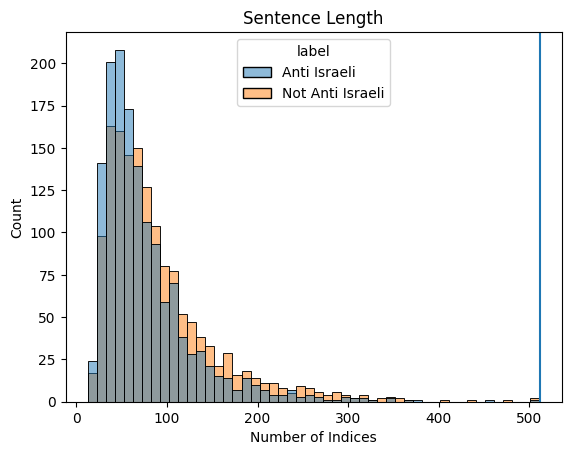

label,Anti Israeli,Not Anti Israeli
Number of Indices,,
True,1439,1482


In [47]:
temp_df = pd.DataFrame(
    {
        'Number of Tokens':EOSs,
        'label': pd.Series(np.squeeze(labels)).map({0:'Not Anti Israeli', 1: 'Anti Israeli'})
    }
)

sns.histplot(data=temp_df, x='Number of Indices', hue = 'label', bins=50)
plt.axvline(x=512)
plt.title('Sentence Length')
plt.show()

pd.crosstab(temp_df['Number of Indices']<=512, temp_df['label'])

It is right that the tokenizer automatically trancates texts at 512 tokens, but as we can see, there is no mass at 512, indicating that most of the data fits the limitation of the Roberta tokenizer.

## Data Processing

In [8]:
sentences = np.array([f'{x} ; {y}' for (x,y) in zip(data['title'].tolist(), zip(data['comment'].tolist()))])
labels    = data[['label']].values

tokenizer = RobertaTokenizer.from_pretrained(HF_BERT_MODEL)
max_len = 512

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in tqdm(sentences, desc='Processing sentences..'):
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Processing sentences..:   0%|          | 0/155 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Processing sentences..: 100%|███████

In [9]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
labels = labels.long()

In [10]:
dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataloader = DataLoader(
            dataset,
            batch_size = 16
        )

## Embeddings

### Pre-trained and Untouched

In [11]:
# Load Model
model = RobertaForSequenceClassification.from_pretrained(
    HF_BERT_MODEL,
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
    ).to(device)

results = {'inputs':[],
          'labels':[],
          'manual_labels':[],
          'CLS_embeddings':[]}


for batch in tqdm(test_dataloader, desc='Collecting results..'):
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

  with torch.no_grad():
      last_hidden_states = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                output_hidden_states=True).\
                                hidden_states[-1].\
                                detach().cpu().numpy()             # Keep last hidden state

      results['inputs']         += b_input_ids.tolist()
      results['labels']         += b_labels.tolist()
      results['CLS_embeddings'] += last_hidden_states[:,0,:].tolist()

print('Input shape:', b_input_ids.shape)
print('Last Hidden layers shape:', last_hidden_states.shape)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Input shape: torch.Size([11, 512])
Last Hidden layers shape: (11, 512, 768)


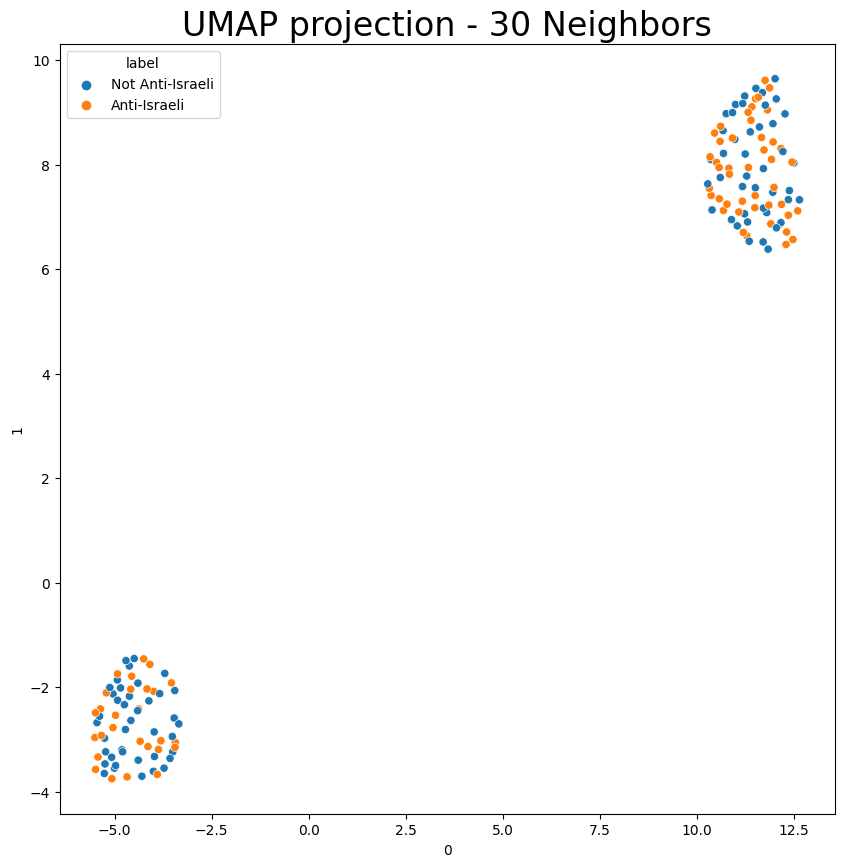

In [12]:
CLS_embeddings_np = np.array(results['CLS_embeddings'])
labels_np = np.squeeze(np.array(results['labels']))

present_umap_embeddings(CLS_embeddings_np, labels_np, n_neighbors=30)

### Continue Pre-training model

In [13]:
sentences = np.array([f'{x} ; {y}' for (x,y) in zip(data['title'].tolist(), zip(data['comment'].tolist()))])
labels    = data[['label']].values

tokenizer = RobertaTokenizer.from_pretrained("./models/roberta-base_pretrained_tokenizer/")
max_len = 512

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in tqdm(sentences, desc='Processing sentences..'):
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
labels = labels.long()

dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataloader = DataLoader(
            dataset,
            batch_size = 16
        )

Processing sentences..:   0%|          | 0/155 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Processing sentences..: 100%|███████

In [14]:
# Load Model
model = RobertaForSequenceClassification.from_pretrained(
    './models/roberta-base_pretrained_80000.pt',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
    ).to(device)

results = {'inputs':[],
          'labels':[],
          'manual_labels':[],
          'CLS_embeddings':[]}


for batch in tqdm(test_dataloader, desc='Collecting results..'):
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

  with torch.no_grad():
      last_hidden_states = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                output_hidden_states=True).\
                                hidden_states[-1].\
                                detach().cpu().numpy()             # Keep last hidden state

      results['inputs']         += b_input_ids.tolist()
      results['labels']         += b_labels.tolist()
      results['CLS_embeddings'] += last_hidden_states[:,0,:].tolist()

print('Input shape:', b_input_ids.shape)
print('Last Hidden layers shape:', last_hidden_states.shape)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./models/roberta-base_pretrained_80000.pt and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Input shape: torch.Size([11, 512])
Last Hidden layers shape: (11, 512, 768)


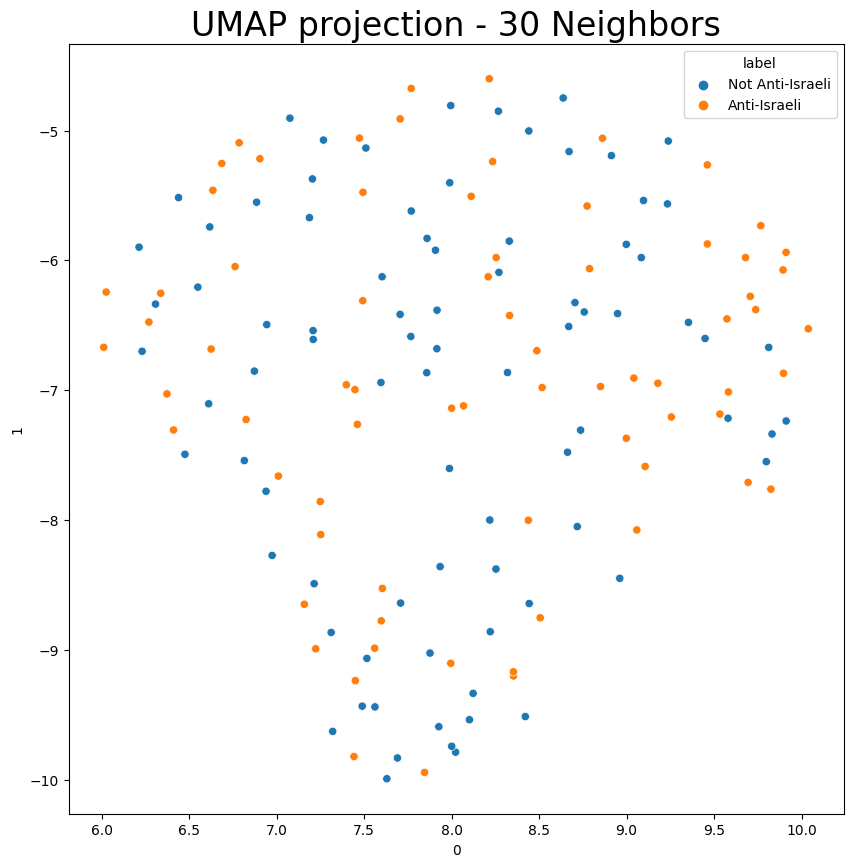

In [15]:
CLS_embeddings_np = np.array(results['CLS_embeddings'])
labels_np = np.squeeze(np.array(results['labels']))

present_umap_embeddings(CLS_embeddings_np, labels_np, n_neighbors=30)

### Fine Tuned Model

In [16]:
# Load Model
model = RobertaForSequenceClassification.from_pretrained(
    "./models/roberta_augmentation_label_spreading_after_pretraining_241123_model.pt",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
    ).to(device)

results = {'inputs':[],
          'labels':[],
          'manual_labels':[],
          'CLS_embeddings':[]}


for batch in tqdm(test_dataloader, desc='Collecting results..'):
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

  with torch.no_grad():
      last_hidden_states = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                output_hidden_states=True).\
                                hidden_states[-1].\
                                detach().cpu().numpy()             # Keep last hidden state

      results['inputs']         += b_input_ids.tolist()
      results['labels']         += b_labels.tolist()
      results['CLS_embeddings'] += last_hidden_states[:,0,:].tolist()

print('Input shape:', b_input_ids.shape)
print('Last Hidden layers shape:', last_hidden_states.shape)

Input shape: torch.Size([11, 512])
Last Hidden layers shape: (11, 512, 768)


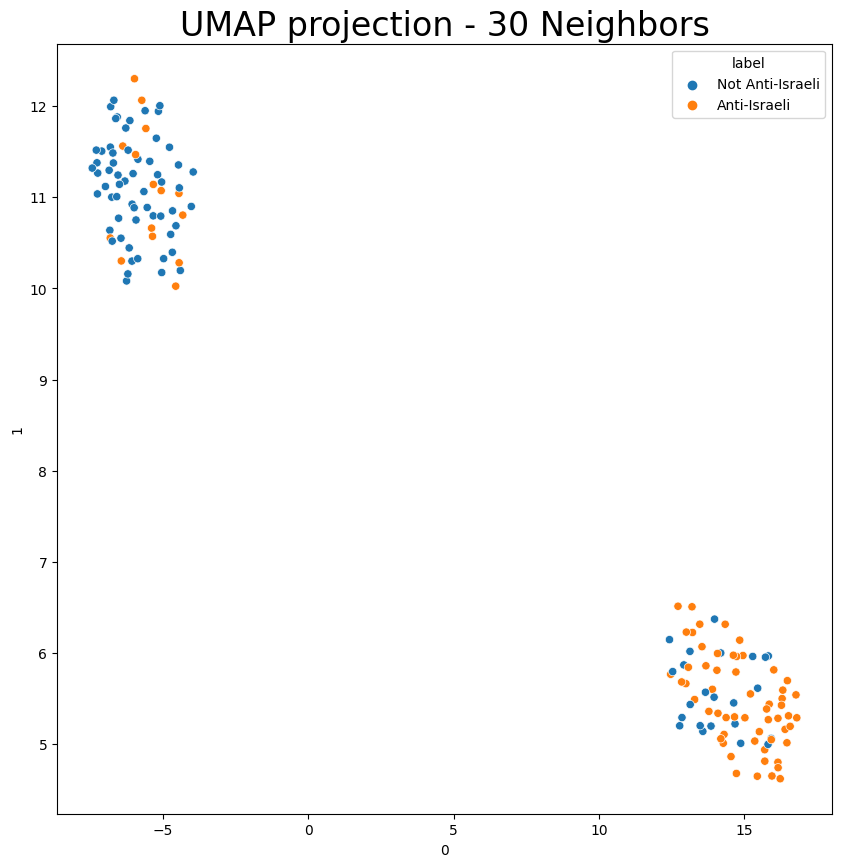

In [17]:
CLS_embeddings_np = np.array(results['CLS_embeddings'])
labels_np = np.squeeze(np.array(results['labels']))

present_umap_embeddings(CLS_embeddings_np, labels_np, n_neighbors=30)

## Scores Distribution

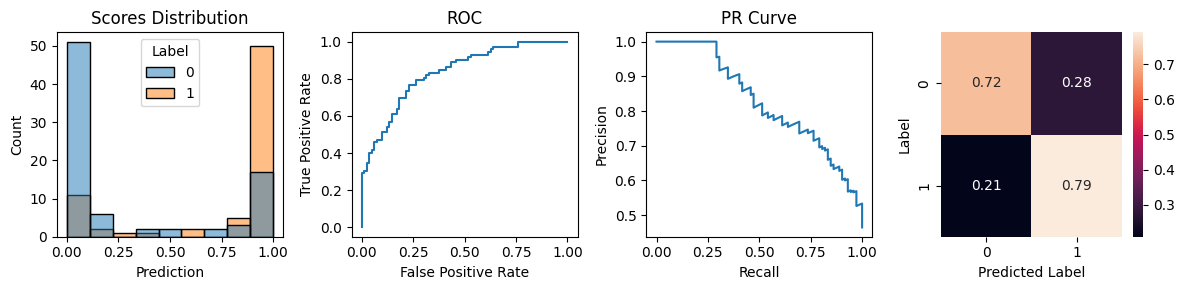

Balanced Accuracy: 0.7573
AUC AUC:           0.834
PR AUC:            0.827


In [33]:
data_with_scores = plot_report_on_test(test_dataloader, model, df_to_score = data)

## Reveal Comments

In [44]:
sorted_data = data_with_scores.sort_values('score',ascending=False)
negative_comment_mask = (sorted_data['label'] == 1)
cols = ['title', 'comment', 'label', 'score']
top_scored_negative_comments_10 = sorted_data[negative_comment_mask][cols].iloc[:10]
top_scored_not_negative_comments_10 = sorted_data[~negative_comment_mask][cols].iloc[:10]

print('Top 10 Negative Examples (correctly classified)')
print('-'*25)
for j in range(10):
  print('Title ; Comment ; Score')
  print(f"{top_scored_negative_comments_10['title'].values[j]} ; {top_scored_negative_comments_10['comment'].values[j]} ; {top_scored_negative_comments_10['score'].values[j]}")
  print('')
print('-'*25)

Top 10 Negative Examples (correctly classified)
-------------------------
Title ; Comment ; Score
Wikileaks: Companies including Coca Cola, Hewlett Packard &amp; Motorola complained of widespread corruption by Israeli officials at Gaza crossing; trucks stalled if firms did not pay bribes.
 ; israel is fucking garbage. ; 0.9977298378944397

Title ; Comment ; Score
Former Israeli soldiers break the silence on military violations
 ; Fuck Israel. ; 0.9976027607917786

Title ; Comment ; Score
To Obama with Love (From Israel)
 ; Hey Israel, we don't want an Obama settlement, get our countries president's name off your murderous countries shit. ; 0.9975388050079346

Title ; Comment ; Score
Egypt cancels Israeli gas contract:  Termination of 20-year deal, which provided 40% of Israel's natural gas, seen as sign of fraying relations between allies

 ; Down with Israel! ; 0.9975258708000183

Title ; Comment ; Score
Egypt warns Israel: Don't interfere with opening of Gaza border crossing
 ; Boyco

In [45]:
print('Top 10 Negative Examples (wrongly classified)')
print('-'*25)
for j in range(10):
  print('Title ; Comment ; Score')
  print(f"{top_scored_not_negative_comments_10['title'].values[j]} ; {top_scored_not_negative_comments_10['comment'].values[j]} ; {top_scored_not_negative_comments_10['score'].values[j]}")
  print('')
print('-'*25)

Top 10 Negative Examples (wrongly classified)
-------------------------
Title ; Comment ; Score
Israelis prepare for war with Iran: Even ex-Mossad chief who opposes an attack on Iran seems to have given up
 ; Oh look, Israel is being an asshole again. Couldn't have predicted this. Now we wait for the UK and the US to join in on the circlejerk. ; 0.9954055547714233

Title ; Comment ; Score
Israelis use clever 'Catch-22' ruse to put thousands of Palestinians between a rock and a hard place, then destroy their homes and schools to make room for an Israeli Military 'training area' in an 'occupied territory' outside of Israel's own border.
 ; As the descendant of a long line of people with brains, I say: Fuck You "Palestinians." The "Palestinians" have no intention of living peaceably with Israel. Israel, shockingly enough, refuses to go away. The "Palestinians" made their beds with suicide/homicide bombers and rockets and mortars. Now they can lie in them, as far as I'm concerned. ; 0.9952